In [2]:
data_dir = '/kaggle/input/zillow-prize-1/'
y_train_2016 = pd.read_csv(f"{data_dir}train_2016_v2.csv")
y_train_2017 = pd.read_csv(f"{data_dir}train_2017.csv")
X_train_2016 = pd.read_csv(f"{data_dir}properties_2016.csv")
X_train_2017 = pd.read_csv(f"{data_dir}properties_2017.csv")
df_submission = pd.read_csv(f"{data_dir}sample_submission.csv")

print(f"\nX_train_2016 shape: {X_train_2016.shape}\ny_train_2016 shape: {y_train_2016.shape}\n2017 X_train shape: {X_train_2017.shape} \
      \n y_train_2017 shape: {y_train_2017.shape}\ntest_data shape:{df_submission.shape}")
del df_submission

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (22,32,34,49,55) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (49) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)



X_train_2016 shape: (2985217, 58)
y_train_2016 shape: (90275, 3)
2017 X_train shape: (2985217, 58)       
 y_train_2017 shape: (77613, 3)
test_data shape:(2985217, 7)


In [3]:
data_type = X_train_2016.dtypes
data_cnt = X_train_2016.nunique()
print(f"frequencey count of differnet types:{collections.Counter(data_type)}")

data_summary = pd.concat([data_type,data_cnt],axis=1)
data_summary.columns = ['dtype','unique_cnt']
print(data_summary.sort_values(['dtype','unique_cnt']))

frequencey count of differnet types:Counter({dtype('float64'): 52, dtype('O'): 5, dtype('int64'): 1})
                                dtype  unique_cnt
parcelid                        int64     2985217
decktypeid                    float64           1
poolcnt                       float64           1
pooltypeid10                  float64           1
pooltypeid2                   float64           1
pooltypeid7                   float64           1
storytypeid                   float64           1
fips                          float64           3
regionidcounty                float64           3
buildingclasstypeid           float64           5
typeconstructiontypeid        float64           5
airconditioningtypeid         float64           7
threequarterbathnbr           float64           7
architecturalstyletypeid      float64           8
fireplacecnt                  float64           9
buildingqualitytypeid         float64          12
numberofstories               float64          1

In [4]:
#object type deepdive
col_object = data_summary.loc[data_summary['dtype']=='object',:].index
X_train_2016.loc[:,col_object].describe()

,hashottuborspa,propertycountylandusecode,propertyzoningdesc,fireplaceflag,taxdelinquencyflag
count,69014,2972940,1978629,5163,56462
unique,1,240,5638,1,1
top,True,0100,LAR1,True,Y
freq,69014,1153896,275029,5163,56462


In [5]:
#convert boolean type to integer
X_2016_clean = X_train_2016.copy()
X_2016_clean[['hashottuborspa','fireplaceflag']] = X_2016_clean[['hashottuborspa','fireplaceflag']].fillna(value=0).astype(int)
X_2016_clean.loc[X_2016_clean.taxdelinquencyflag=='Y','taxdelinquencyflag'] = 1.0
X_2016_clean.loc[X_2016_clean.taxdelinquencyflag!='Y','taxdelinquencyflag'] = 0.0
col_str = ['propertycountylandusecode','propertyzoningdesc']
for col in col_str:
    uniq_val = X_2016_clean[col].unique()
    df_encoding = pd.DataFrame(np.arange(len(uniq_val)),columns=[col+'_e'])
    df_encoding[col] = uniq_val
    X_2016_clean = pd.merge(X_2016_clean, df_encoding, on=[col], how='left')
    X_2016_clean.drop(col,axis=1,inplace=True)
    X_2016_clean.rename(columns={col+"_e":col},inplace=True)

#convert boolean type to integer
X_2017_clean = X_train_2017.copy()
X_2017_clean[['hashottuborspa','fireplaceflag']] = X_2017_clean[['hashottuborspa','fireplaceflag']].fillna(value=0).astype(int)
X_2017_clean.loc[X_2017_clean.taxdelinquencyflag=='Y','taxdelinquencyflag'] = 1.0
X_2017_clean.loc[X_2017_clean.taxdelinquencyflag!='Y','taxdelinquencyflag'] = 0.0
col_str = ['propertycountylandusecode','propertyzoningdesc']
for col in col_str:
    uniq_val = X_2017_clean[col].unique()
    df_encoding = pd.DataFrame(np.arange(len(uniq_val)),columns=[col+'_e'])
    df_encoding[col] = uniq_val
    X_2017_clean = pd.merge(X_2017_clean, df_encoding, on=[col], how='left')
    X_2017_clean.drop(col,axis=1,inplace=True)
    X_2017_clean.rename(columns={col+"_e":col},inplace=True)

del X_train_2016, X_train_2017


<a id="1.4"></a>
### Missing Rate and Null Treatment
* Missing Rate: 17 features with more than 90% missing, could drop these. 
* Null treatment: 9 features with significant missing rate between 0.5 to 0.9, worth deepdive to identify appropriate imputation strategy: impute 4 count variable missing to 0.

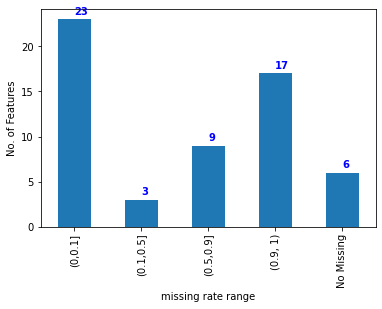

In [6]:
data_summary['missing_rate'] = 1 - X_2016_clean.count()/X_2016_clean.shape[0]
#missing rate when joined with target
train_data = pd.merge(y_train_2016, X_2016_clean, on=['parcelid'],how='left')
mr = 1-train_data.count()/train_data.shape[0]
mr.name = 'missing_rate_sample'
# data_summary.drop('missing_rate_sample', axis=1, inplace=True)
data_summary = pd.concat([data_summary, mr],axis=1)

mr = data_summary.copy()
mr.loc[mr.missing_rate==0,'mr_type'] = 'No Missing'
mr.loc[mr.missing_rate>0,'mr_type'] = '(0,0.1]'
mr.loc[mr.missing_rate>0.1,'mr_type'] = '(0.1,0.5]'
mr.loc[mr.missing_rate>0.5,'mr_type'] = '(0.5,0.9]'
mr.loc[mr.missing_rate>0.9,'mr_type'] = '(0.9, 1)'
df_plt = mr.groupby('mr_type')['dtype'].count()
ax = df_plt.plot(kind='bar')
ax.set_ylabel('No. of Features')
ax.set_xlabel('missing rate range')
for i, v in enumerate(df_plt):
    ax.text(i,v + 0.5,str(v), color='blue', fontweight='bold')
# data_summary.sort_values('missing_rate_sample',ascending=False)

In [7]:
df_impute = mr.loc[mr.mr_type.isin(['(0.5,0.9]','(0.1,0.5]']),:]
X_2016_clean[df_impute.index].describe().T

,count,mean,std,min,25%,50%,75%,max
airconditioningtypeid,811519.0,1.931166,3.148587,1.0,1.0,1.0,1.0,13.0
buildingqualitytypeid,1938488.0,5.784787,1.805352,1.0,4.0,7.0,7.0,12.0
fireplacecnt,312637.0,1.168710,0.461273,1.0,1.0,1.0,1.0,9.0
garagecarcnt,883267.0,1.823517,0.610035,0.0,2.0,2.0,2.0,25.0
garagetotalsqft,883267.0,383.769357,245.443419,0.0,324.0,441.0,494.0,7749.0
heatingorsystemtypeid,1806401.0,4.012053,3.293733,1.0,2.0,2.0,7.0,24.0
poolcnt,517534.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
pooltypeid7,485459.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
regionidneighborhood,1156402.0,193476.407415,165713.254317,6952.0,46736.0,118920.0,274800.0,764167.0
threequarterbathnbr,311631.0,1.010009,0.117709,1.0,1.0,1.0,1.0,7.0


In [8]:
#impute missing count without 0 with 0
col1 = list(set(list(df_impute.index.values)) - 
set([c for c in df_impute.index if 'garage' in c]+
    ['regionidneighborhood','numberofstories','unitcnt','airconditioningtypeid','buildingqualitytypeid','heatingorsystemtypeid'])) 
X_2016_clean[col1] = X_2016_clean[col1].fillna(value=0)

#fill pool id and area with 0 if poolcnt = 0
col1 = ['pooltypeid2','pooltypeid7','pooltypeid10','poolsizesum']
X_2016_clean.loc[X_2016_clean.poolcnt==0,col1] = 0

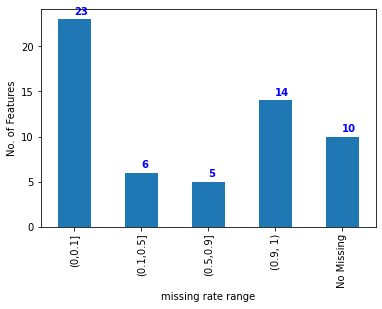

In [9]:
data_summary['missing_rate'] = 1 - X_2016_clean.count()/X_2016_clean.shape[0]
#missing rate when joined with target
train_data = pd.merge(y_train_2016, X_2016_clean, on=['parcelid'],how='left')
mr = 1-train_data.count()/train_data.shape[0]
mr.name = 'missing_rate_sample'
data_summary.drop('missing_rate_sample', axis=1, inplace=True)
data_summary = pd.concat([data_summary, mr],axis=1)

mr = data_summary.copy()
mr.loc[mr.missing_rate==0,'mr_type'] = 'No Missing'
mr.loc[mr.missing_rate>0,'mr_type'] = '(0,0.1]'
mr.loc[mr.missing_rate>0.1,'mr_type'] = '(0.1,0.5]'
mr.loc[mr.missing_rate>0.5,'mr_type'] = '(0.5,0.9]'
mr.loc[mr.missing_rate>0.9,'mr_type'] = '(0.9, 1)'
df_plt = mr.groupby('mr_type')['dtype'].count()
ax = df_plt.plot(kind='bar')
ax.set_ylabel('No. of Features')
ax.set_xlabel('missing rate range')
for i, v in enumerate(df_plt):
    ax.text(i,v + 0.5,str(v), color='blue', fontweight='bold')
# data_summary.sort_values('missing_rate_sample',ascending=False)

<a id="2"></a>
## Target Variable
* Clearly there are quite a bit of outliers in target variable

<a id="2.1"></a>
### Time Series
* Clear Seasonality in Volume, seasonal dummy as features
* Outliers each month
* Multiple transaction per properties: 320


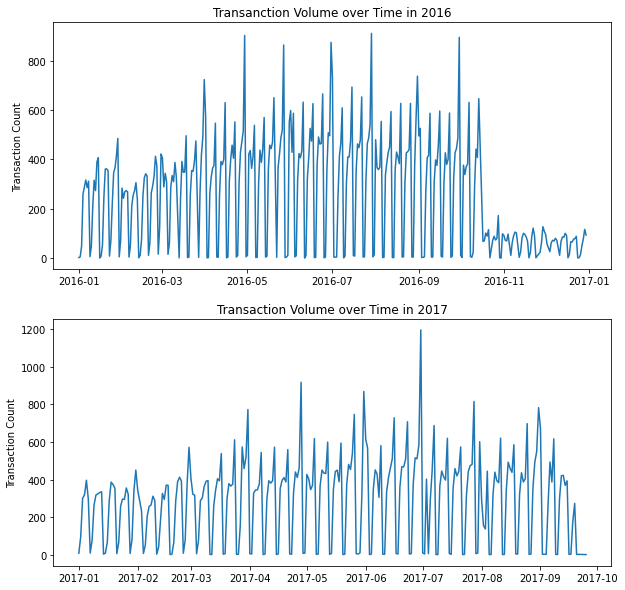

In [10]:
#count over time
date_col ='transactiondate'
y_train_2016['date_'] = y_train_2016[date_col].apply(lambda x: pd.Timestamp(x))
y_train_2017['date_'] = y_train_2017[date_col].apply(lambda x: pd.Timestamp(x))

fig, ax = plt.subplots(2,1,figsize=(10,10))
ys = [y_train_2016, y_train_2017]
titles = ['Transanction Volume over Time in 2016', 'Transaction Volume over Time in 2017']
for i, y in enumerate(ys):
    plti = y.groupby('date_')['logerror'].count()
    ax[i].plot(plti.index, plti.values)
    ax[i].set_title(titles[i])
    ax[i].set_ylabel('Transaction Count')
    
    

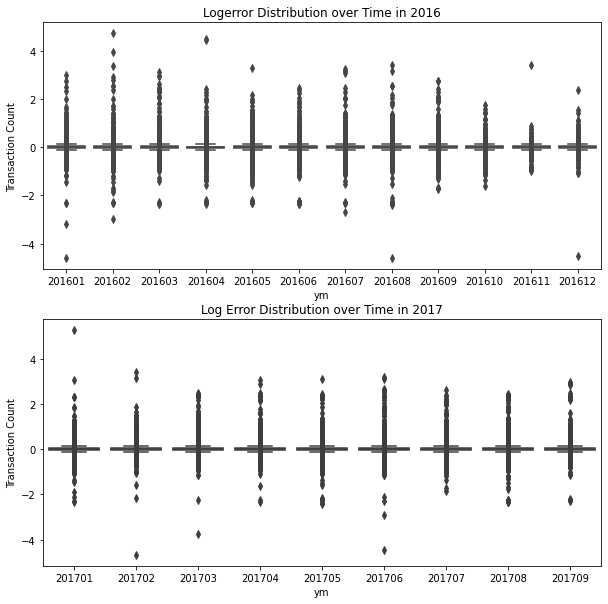

In [11]:
#boxplot over time
fig, ax = plt.subplots(2,1,figsize=(10,10))
ys = [y_train_2016, y_train_2017]
titles = ['Logerror Distribution over Time in 2016', 'Log Error Distribution over Time in 2017']
for i, y in enumerate(ys):
    y['ym'] = y.date_.apply(lambda x: x.year*100 + x.month)
    sns.boxplot(x='ym',y='logerror', data=y, ax=ax[i])
    ax[i].set_title(titles[i])
    ax[i].set_ylabel('Transaction Count')


* How many properties have more than one transactions in 2016/2017?


In [12]:
transaction_2016_cnt = y_train_2016.groupby('parcelid')['transactiondate'].count()
transaction_2017_cnt = y_train_2017.groupby('parcelid')['transactiondate'].count()
multiple_2016 = transaction_2016_cnt[transaction_2016_cnt>1]
multiple_2017 = transaction_2017_cnt[transaction_2017_cnt>1]
print(f"{len(multiple_2016)+len(multiple_2017)} properties have multiple transactions within 2016 or 2017")


320 properties have multiple transactions within 2016 or 2017


<a id="2.2"></a>
### Unconditional Distribution 
* comparison between raw and winsorized data
* winsorize by yearmon at different threshold

Text(0.5, 0, 'logerror')

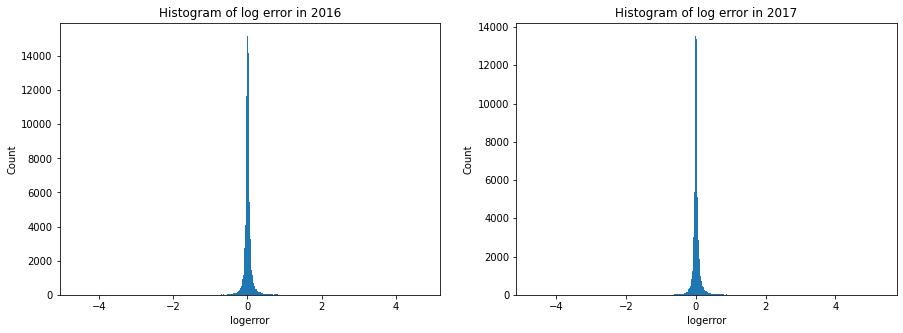

In [13]:
#raw historgram
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].hist(y_train_2016.logerror,500)
ax[0].set_title('Histogram of log error in 2016')
ax[0].set_ylabel('Count')
ax[0].set_xlabel('logerror')
ax[1].hist(y_train_2017.logerror,500)
ax[1].set_title('Histogram of log error in 2017')
ax[1].set_ylabel('Count')
ax[1].set_xlabel('logerror')

Text(0.5, 0, 'winsorized by ym at [0.01,0.99] logerror')

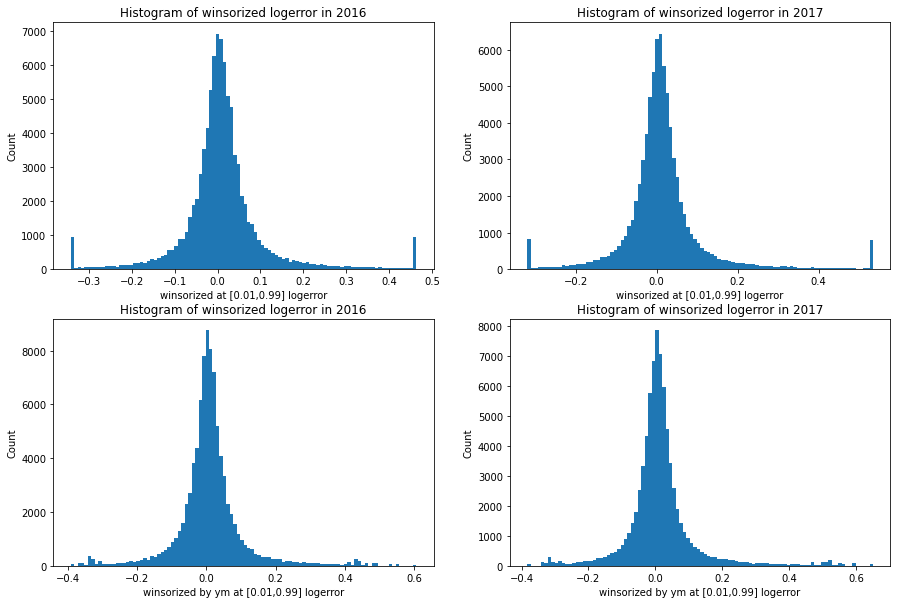

In [14]:
#winsorize
def winsorize(df,date_col,data_col,limit=[0.01,0.99]):
    df['ym'] = df[date_col].apply(lambda x: x.year*100 + x.month)
    df[data_col+'_wc_'+str(limit[0])] = df.groupby('ym')[data_col].transform(lambda x: x.clip(*x.quantile(limit)))
    df[data_col+'_w_'+str(limit[0])] = df[data_col].transform(lambda x: x.clip(*x.quantile(limit)))
    return df
y_train_2016 = winsorize(y_train_2016,'date_','logerror',[0.01,0.99])
y_train_2017 = winsorize(y_train_2017,'date_','logerror',[0.01,0.99])

#outlier transform
fig, ax = plt.subplots(2,2,figsize=(15,10))
ax = ax.ravel()
ax[0].hist(y_train_2016['logerror_w_0.01'],100)
ax[0].set_title('Histogram of winsorized logerror in 2016')
ax[0].set_ylabel('Count')
ax[0].set_xlabel('winsorized at [0.01,0.99] logerror')
ax[1].hist(y_train_2017['logerror_w_0.01'],100)
ax[1].set_title('Histogram of winsorized logerror in 2017')
ax[1].set_ylabel('Count')
ax[1].set_xlabel('winsorized at [0.01,0.99] logerror')
ax[2].hist(y_train_2016['logerror_wc_0.01'],100)
ax[2].set_title('Histogram of winsorized logerror in 2016')
ax[2].set_ylabel('Count')
ax[2].set_xlabel('winsorized by ym at [0.01,0.99] logerror')
ax[3].hist(y_train_2017['logerror_wc_0.01'],100)
ax[3].set_title('Histogram of winsorized logerror in 2017')
ax[3].set_ylabel('Count')
ax[3].set_xlabel('winsorized by ym at [0.01,0.99] logerror')


Text(0.5, 0, 'winsorized by ym at [0.05,0.95] logerror')

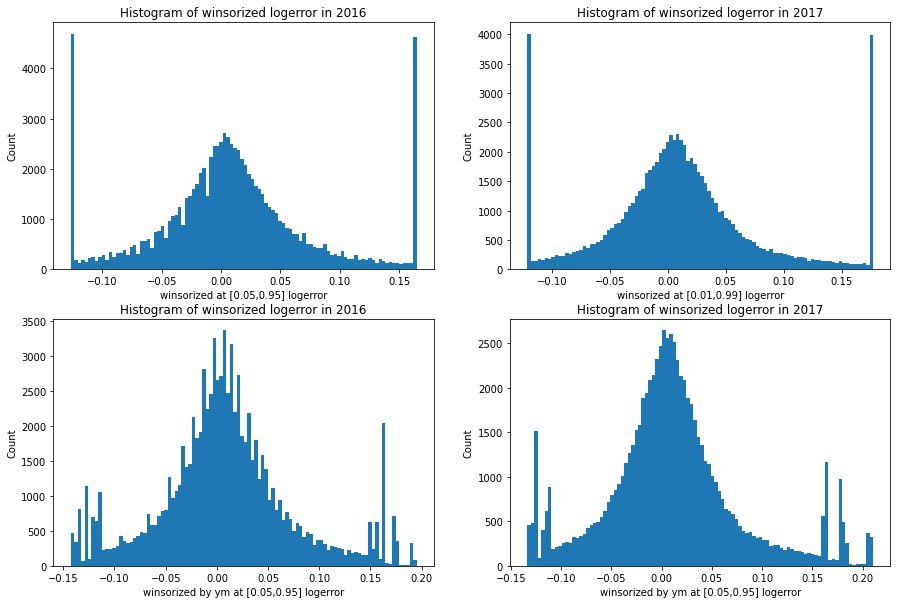

In [15]:
y_train_2016 = winsorize(y_train_2016,'date_','logerror',[0.05,0.95])
y_train_2017 = winsorize(y_train_2017,'date_','logerror',[0.05,0.95])
fig, ax = plt.subplots(2,2,figsize=(15,10))
ax = ax.ravel()
ax[0].hist(y_train_2016['logerror_w_0.05'],100)
ax[0].set_title('Histogram of winsorized logerror in 2016')
ax[0].set_ylabel('Count')
ax[0].set_xlabel('winsorized at [0.05,0.95] logerror')
ax[1].hist(y_train_2017['logerror_w_0.05'],100)
ax[1].set_title('Histogram of winsorized logerror in 2017')
ax[1].set_ylabel('Count')
ax[1].set_xlabel('winsorized at [0.01,0.99] logerror')
ax[2].hist(y_train_2016['logerror_wc_0.05'],100)
ax[2].set_title('Histogram of winsorized logerror in 2016')
ax[2].set_ylabel('Count')
ax[2].set_xlabel('winsorized by ym at [0.05,0.95] logerror')
ax[3].hist(y_train_2017['logerror_wc_0.05'],100)
ax[3].set_title('Histogram of winsorized logerror in 2017')
ax[3].set_ylabel('Count')
ax[3].set_xlabel('winsorized by ym at [0.05,0.95] logerror')


<a id="2.3"></a>
### Conditional Distribution
* Simple 1-d Gaussian Mixture Model 

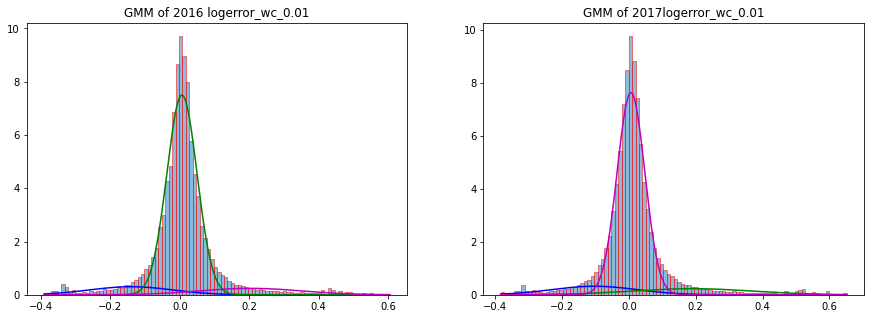

In [16]:
from sklearn import mixture 
vname = 'logerror_wc_0.01'
titles = ['GMM of 2016 '+vname,'GMM of 2017'+vname]
fig, ax = plt.subplots(1,2,figsize=(15,5))
for i, y in enumerate(ys):
        
    f = y[[vname]]

    g = mixture.GaussianMixture(n_components=3,covariance_type='full')
    g.fit(f)
    weights = g.weights_
    means = g.means_
    covars = g.covariances_

    ax[i].hist(f, bins=100, histtype='bar', density=True, ec='red', alpha=0.5)
    f_axis = f.copy()
    f_axis.sort_values(vname,inplace=True)
    ax[i].plot(f_axis,weights[0]*stats.norm.pdf(f_axis,means[0][0],np.sqrt(covars[0][0])).ravel(), c='blue')
    ax[i].plot(f_axis,weights[1]*stats.norm.pdf(f_axis,means[1][0],np.sqrt(covars[1][0])).ravel(), c='green')
    ax[i].plot(f_axis,weights[2]*stats.norm.pdf(f_axis,means[2][0],np.sqrt(covars[2][0])).ravel(), c='m')
    ax[i].set_title(titles[i])

* Anything special for properties with multiple transactions?

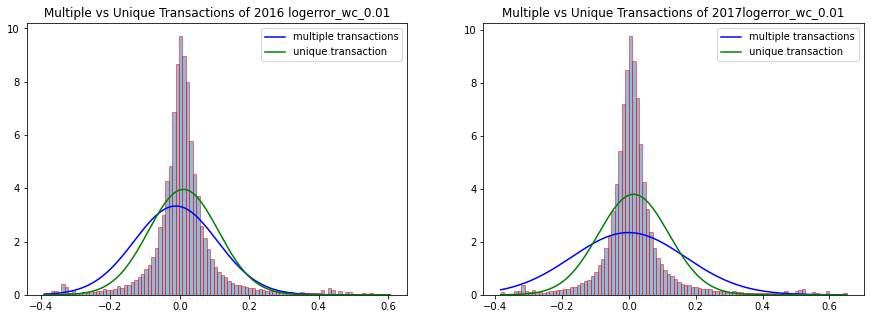

In [17]:
vname = 'logerror_wc_0.01'
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax = ax.ravel()
titles = ['Multiple vs Unique Transactions of 2016 '+vname,'Multiple vs Unique Transactions of 2017'+vname]
for i, y in enumerate(ys):
    cnt = y.groupby('parcelid')['transactiondate'].count()
    idx = cnt[cnt>1].index
    f = y[[vname]]
    f1 = y.loc[y.parcelid.isin(idx),vname]
    f2 = y.loc[~y.parcelid.isin(idx),vname]  
    ax[i].hist(f, bins=100, histtype='bar', density=True, ec='red', alpha=0.5)
    f_axis = f.copy()
    f_axis.sort_values(vname,inplace=True)
    ax[i].plot(f_axis,stats.norm.pdf(f_axis,np.mean(f1),np.std(f1)).ravel(), c='blue',label='multiple transactions')
    ax[i].plot(f_axis,stats.norm.pdf(f_axis,np.mean(f2),np.std(f2)).ravel(), c='green',label='unique transaction')    
    ax[i].set_title(titles[i])
    ax[i].legend()

<a id="3"></a>
## Features

<a id="3.1"></a>
### Catgorical Features
* Filter by Missing Rate: three categorical variables with many unique values, drop ['propertyzoningdesc','censustractandblock','rawcensustractandblock']
* Distribution: class imbalance, drop ['pooltypeid10','pooltypeid2','fireplaceflag','taxdelinquencyflag']
* Encode categorical variables with One Hot Encoder. 
<!-- * Relationship with Target: scatter plot of group median
# * Relationship with each other: correlation, hierarchical clustering (gower taking too long), remove highly correlated ones. 
# * Feature Importance: RF
#  -->

In [18]:
col_categorical = col_str + [c for c in X_2016_clean.columns if 'typeid' in c or 'region' in c] +\
['fips','rawcensustractandblock','censustractandblock']
col_rest = list(set(X_2016_clean.columns) - set(col_categorical))
col_rest = [c for c in col_rest if data_summary.loc[c,'unique_cnt']==1]
col_categorical = col_categorical + col_rest
print(f'{len(col_categorical)} categorical featrues identified')
col_categorical_filtered = [c for c in col_categorical if data_summary.loc[c,'missing_rate']<=0.5]
print(f'{len(col_categorical_filtered)} categorical features after filtering out high missing rate.')
l1 = X_2016_clean.shape[1] 
data_summary.loc[col_categorical_filtered,:].sort_values('unique_cnt')


25 categorical featrues identified
18 categorical features after filtering out high missing rate.


,dtype,unique_cnt,missing_rate,missing_rate_sample
poolcnt,float64,1.0,0.000000,0.000000
taxdelinquencyflag,object,1.0,0.000000,0.000000
pooltypeid10,float64,1.0,0.173366,0.198294
pooltypeid2,float64,1.0,0.162621,0.184957
pooltypeid7,float64,1.0,0.000000,0.000000
hashottuborspa,object,1.0,0.000000,0.000000
fireplaceflag,object,1.0,0.000000,0.000000
regionidcounty,float64,3.0,0.003831,0.000000
fips,float64,3.0,0.003831,0.000000
buildingqualitytypeid,float64,12.0,0.350637,0.364564


<a id="3.1.1"></a>
#### Distribution
* Four variables have very high class imabalance or only one value for all observations, should be dropped: pooltypeid10,pooltypeid2,fireplaceflag,taxdelinquencyflag

15 categorical features after filtering out features with too many unique values.
propertycountylandusecode start.
buildingqualitytypeid start.
heatingorsystemtypeid start.
pooltypeid10 start.
pooltypeid2 start.
pooltypeid7 start.
propertylandusetypeid start.
regionidcity start.
regionidcounty start.
regionidzip start.
fips start.
fireplaceflag start.
taxdelinquencyflag start.
hashottuborspa start.
poolcnt start.
11 categorical features after filtering out features with highly imbalanced class distrubtion.


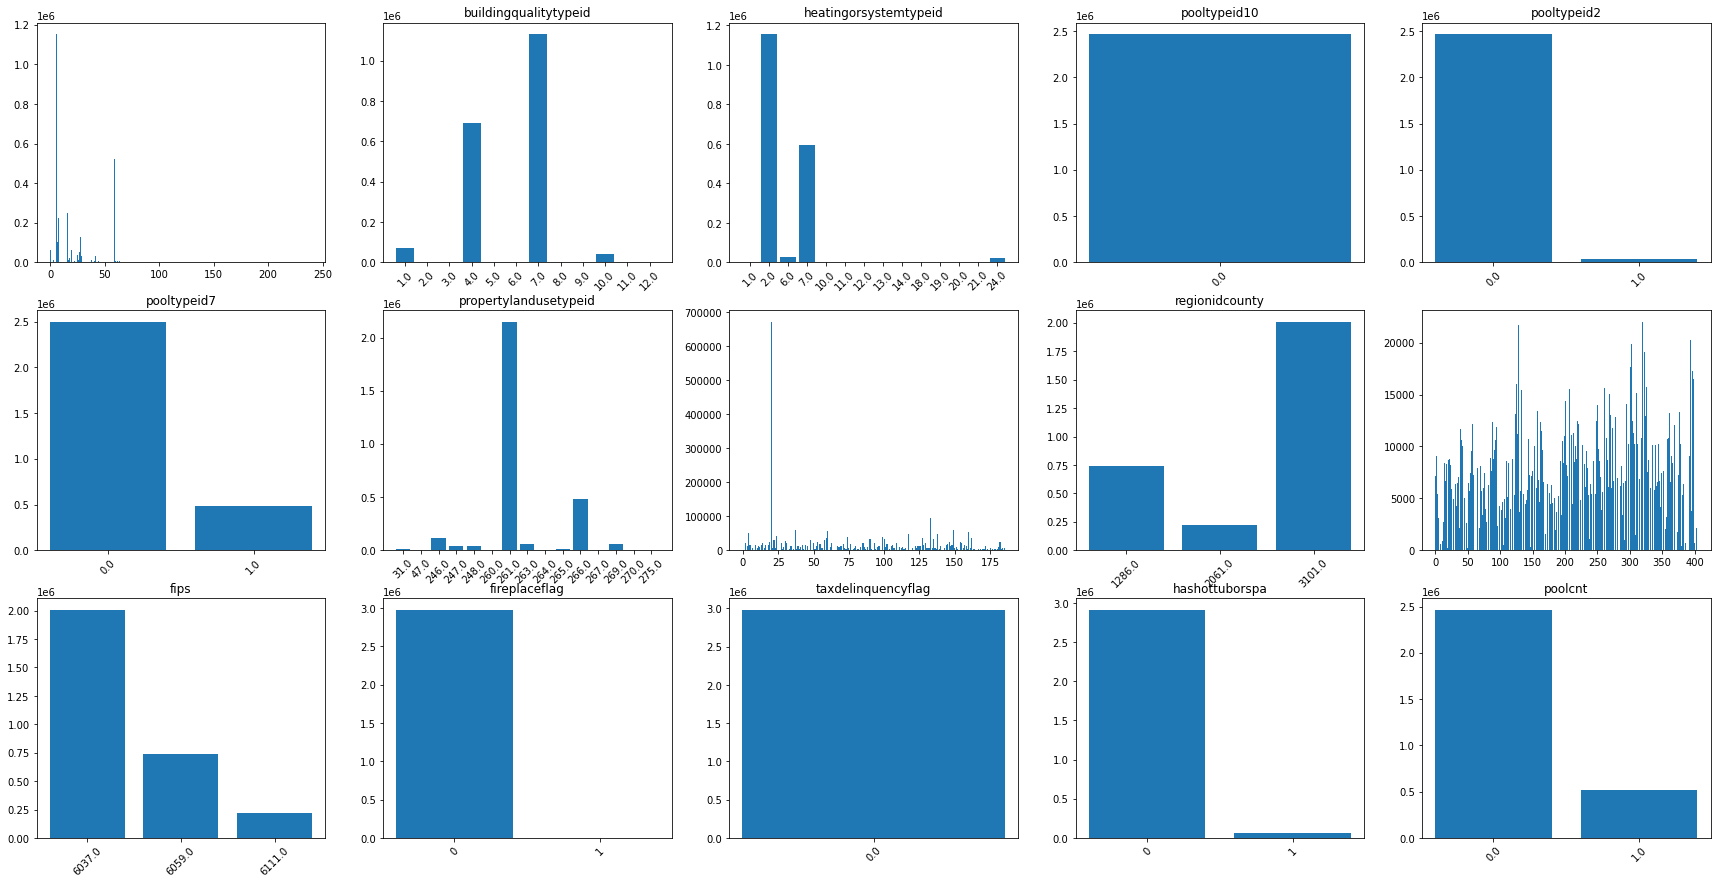

In [19]:
#Frequency chart
col_drop = ['propertyzoningdesc','censustractandblock','rawcensustractandblock']
col_categorical_filtered = [c for c in col_categorical_filtered if c not in col_drop]
print(f'{len(col_categorical_filtered)} categorical features after filtering out features with too many unique values.')
fig, ax =plt.subplots(3,5, figsize=(30,15))
ax = ax.ravel()
for i, c in enumerate(col_categorical_filtered):
    print(f"{c} start.")
    df_plt = X_2016_clean.loc[X_2016_clean[c].notnull(),:]
    df_br= df_plt.groupby(c)['parcelid'].count()
    bri = np.arange(df_br.shape[0])
    ax[i].bar(bri, df_br.values)
    if data_summary.loc[c,'unique_cnt']<100:
        ax[i].set_xticks(bri)
        ax[i].set_xticklabels(df_br.index,rotation=45)
        ax[i].set_title(c)
#     df_plt = X_2016_clean.loc[X_2016_clean[c].notnull(),:]
#     ax[i].hist(df_plt[c])
#     ax[i].set_title(c)
col_drop =  ['pooltypeid10','pooltypeid2','fireplaceflag','taxdelinquencyflag']
col_categorical_filtered = [c for c in col_categorical_filtered if c not in col_drop]
del df_plt, df_br

<!-- <a id="3.1.2"></a>
#### Correlation with Y -->

In [22]:
dummies = []
for c in col_categorical_filtered:
    cnt = X_2016_clean[c].nunique()
    if cnt <100:
        print(f"dummy for {c} created.")
        dummy_i = pd.get_dummies(X_2016_clean[c], prefix=f'dummy_{c}')
        dummy_i = dummy_i.iloc[:,:-1]
        dummies.append(dummy_i)
dummies = pd.concat(dummies, axis=1)
X_2016_clean = pd.concat([X_2016_clean,dummies], axis=1)
l2 = X_2016_clean.shape[1]
print(f"{l2-l1} categorical dummies created.")

dummy for buildingqualitytypeid created.
dummy for heatingorsystemtypeid created.
dummy for pooltypeid7 created.
dummy for propertylandusetypeid created.
dummy for regionidcounty created.
dummy for fips created.
dummy for hashottuborspa created.
dummy for poolcnt created.
45 categorical dummies created.


In [23]:
# fig, ax =plt.subplots(4,5, figsize=(30,20))
# ax = ax.ravel()


# for i, c in enumerate(col_categorical_filtered):
#     print(f"{c} start.")
#     df_plt = train_data.loc[train_data[c].notnull(),:]
#     df_br= df_plt.groupby(c)['logerror_wc_0.01'].median()
#     bri = np.arange(df_br.shape[0])
#     ax[i].scatter(bri, df_br.values)
#     if data_summary.loc[c,'unique_cnt']<100:
#         ax[i].set_xticks(bri)
#         ax[i].set_xticklabels(df_br.index,rotation=45)
#     ax[i].set_title(c)

<!-- <a id="3.1.3"></a>
#### Correlation within X -->

In [24]:
# col_categorical_filtered = [c for c in col_categorical_filtered if c not in ['pooltypeid2','pooltypeid7','pooltypeid10','fireplaceflag','taxdelinquencyflag']]
# print(f"Drop uninformative features. Left with {len(col_categorical_filtered)} categorical features.")
# fig, ax = plt.subplots(figsize=(15, 15)) 
# mask = np.zeros_like(train_data[col_categorical_filtered].corr())
# mask[np.triu_indices_from(mask)] = 1
# sns.heatmap(train_data[col_categorical_filtered].corr(method='spearman'), mask= mask, ax= ax, annot= True)

<a id="3.2"></a>
### Numeric Features

* Filter by Missing Rate
* Distribution: histogram, summary table: outlier, needs winsorize
* Relationship with Target: time series correlation stable.
* Relationship with each other: correlation, remove highly correlated ones
* Feature Importance: RF


In [25]:
col_dummy = [c for c in X_2016_clean if 'dummy' in c]
col_numeric = list(set(X_2016_clean.columns) - set(col_categorical+col_dummy))

print(f'{len(col_numeric)} numeric featrues identified')
col_numeric_filtered = [c for c in col_numeric if data_summary.loc[c,'missing_rate']<0.5]
print(f'{len(col_numeric_filtered)} numeric features after filtering out high missing rate.')
data_summary.loc[col_numeric,:]

33 numeric featrues identified
21 numeric features after filtering out high missing rate.


,dtype,unique_cnt,missing_rate,missing_rate_sample
yardbuildingsqft17,float64,1636.0,0.973082,0.970690
poolsizesum,float64,907.0,0.163999,0.187560
finishedfloor1squarefeet,float64,4604.0,0.932093,0.924054
yardbuildingsqft26,float64,594.0,0.999113,0.998948
threequarterbathnbr,float64,7.0,0.000000,0.000000
bedroomcnt,float64,21.0,0.003836,0.000000
garagetotalsqft,float64,2240.0,0.704120,0.668380
numberofstories,float64,12.0,0.771518,0.772141
lotsizesquarefeet,float64,69953.0,0.092489,0.112434
taxamount,float64,1045757.0,0.010468,0.000066


<a id="3.2.1"></a>
#### Distribution
* Many distributions indicate outliers. Some might need winsorization depending on the model we use. These include: unitcnt, finishedsquarefeet2, structuretaxvaluedollarcnt, landtaxvaluedollarcnt, calculatedfinishedsquarefeet, taxamount,landtaxvaluedollarcnt,lotsizesquarefeet, taxvaluedollarcnt, roomcnt.

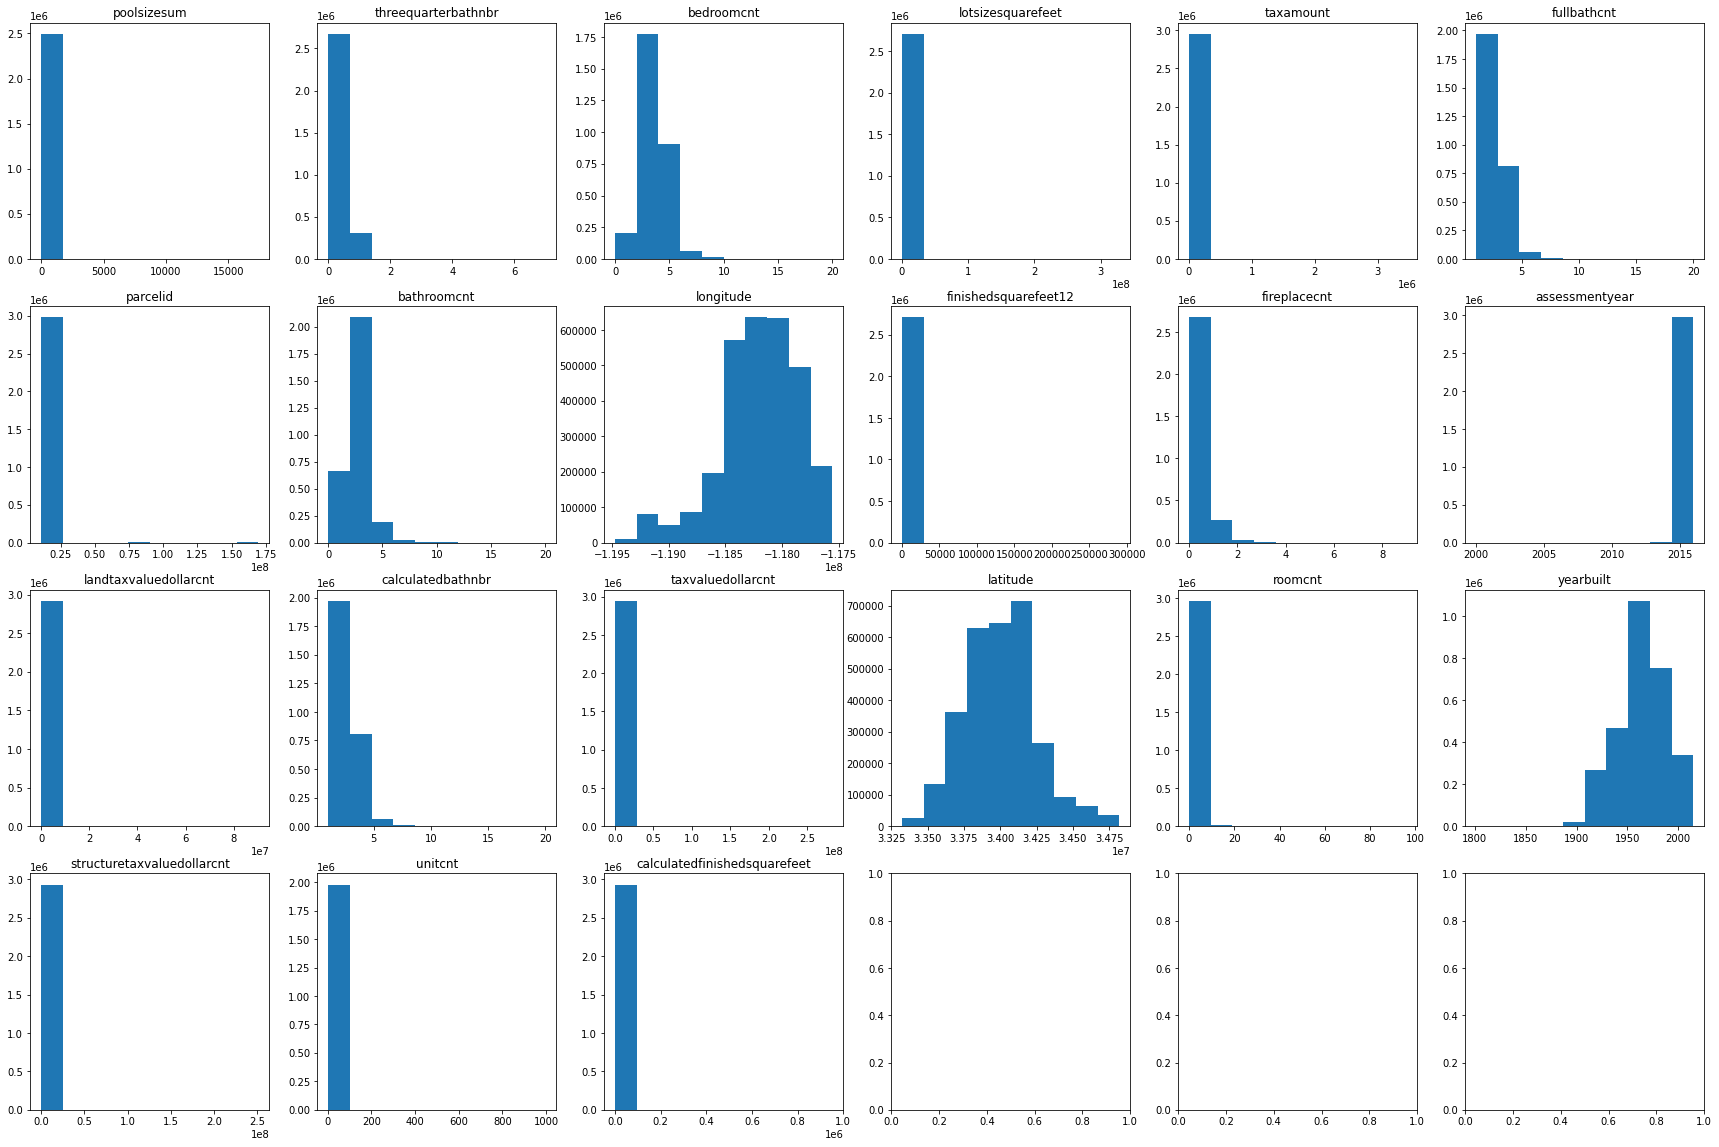

In [26]:
#Histogram in full sample
fig, ax =plt.subplots(4,6, figsize=(30,20))
ax = ax.ravel()
for i, c in enumerate(col_numeric_filtered):
#     print(f"{c} start.")
    df_plt = X_2016_clean.loc[X_2016_clean[c].notnull(),:]
    ax[i].hist(df_plt[c])
    ax[i].set_title(c)

In [27]:
df_summary = X_2016_clean[col_numeric_filtered].describe()
df_summary.T

,count,mean,std,min,25%,50%,75%,max
poolsizesum,2495643.0,5.822595e+00,5.832882e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.741000e+04
threequarterbathnbr,2985217.0,1.054362e-01,3.111609e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e+00
bedroomcnt,2973767.0,3.088949e+00,1.275859e+00,0.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,2.000000e+01
lotsizesquarefeet,2709118.0,2.282281e+04,3.375924e+05,1.000000e+02,5.688000e+03,7.000000e+03,9.898000e+03,3.282638e+08
taxamount,2953967.0,5.377607e+03,9.183107e+03,1.340000e+00,2.461070e+03,3.991780e+03,6.201005e+03,3.458861e+06
fullbathcnt,2856305.0,2.244165e+00,9.912054e-01,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,2.000000e+01
parcelid,2985217.0,1.332586e+07,7.909966e+06,1.071172e+07,1.164371e+07,1.254509e+07,1.409712e+07,1.696019e+08
bathroomcnt,2973755.0,2.209143e+00,1.077754e+00,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,2.000000e+01
longitude,2973780.0,-1.182019e+08,3.453171e+05,-1.194758e+08,-1.183930e+08,-1.181725e+08,-1.179495e+08,-1.175543e+08
finishedsquarefeet12,2709184.0,1.760001e+03,9.710610e+02,1.000000e+00,1.196000e+03,1.539000e+03,2.070000e+03,2.903450e+05


<a id="3.2.2"></a>
#### Correlation with Y

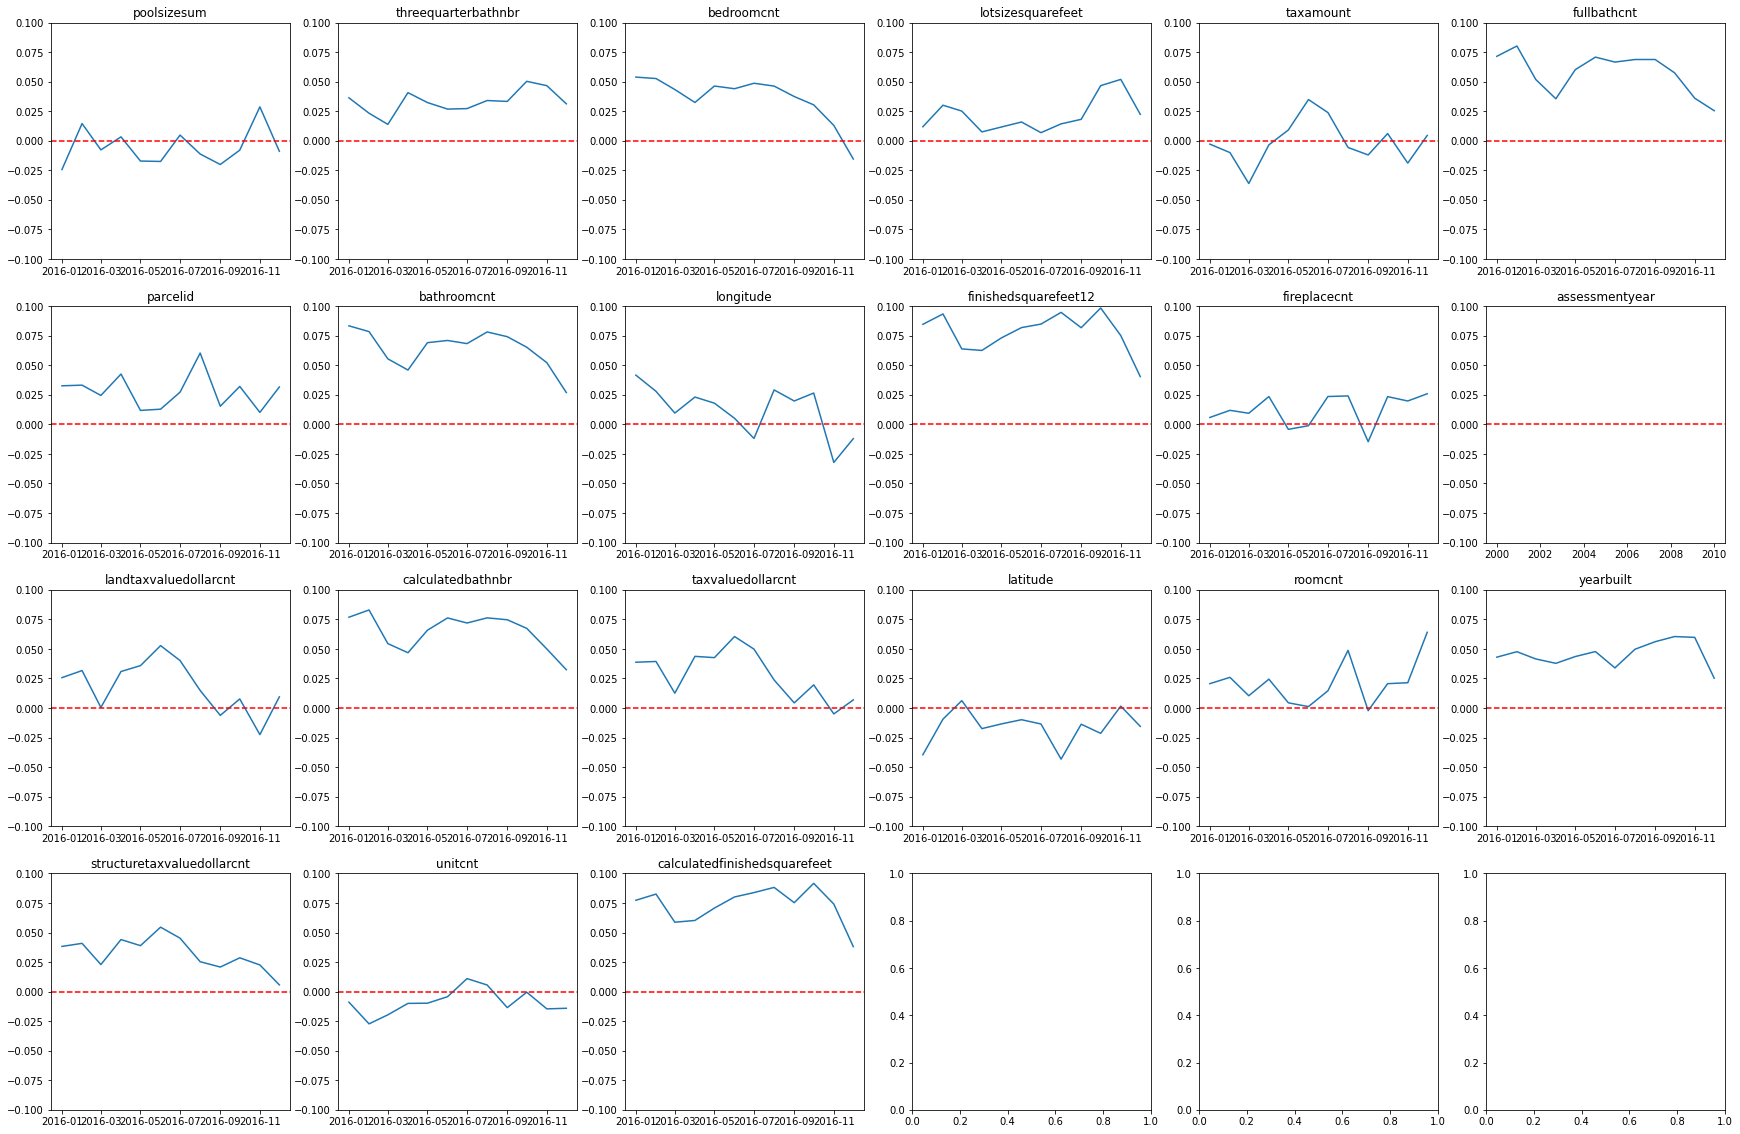

In [28]:
# correlation time series with y
date_col = 'transactiondate'
train_data['date_'] = train_data[date_col].apply(lambda x: pd.Timestamp(x))
# train_data['ym'] = train_data['date_'].apply(lambda x:x.year*100+x.month)
train_data = winsorize(train_data,'date_','logerror',[0.01,0.99])
corr1 = train_data.groupby('ym').corr(method='spearman').reset_index()
corr1 = corr1.loc[corr1.level_1=='logerror_wc_0.01',['ym']+col_numeric_filtered]
corr1['date_'] = corr1['ym'].apply(lambda x: pd.Timestamp(f"{str(x)[0:4]}-{str(x)[4:6]}-01"))
fig, ax =plt.subplots(4,6, figsize=(30,20))
ax = ax.ravel()

for i, c in enumerate(col_numeric_filtered):
    ax[i].plot(corr1.date_, corr1[c].values)
    ax[i].set_title(c)
    ax[i].set_ylim([-0.1,0.1])
    ax[i].axhline(y=0,color='r',linestyle='--')

<a id="3.2.3"></a>
#### Correlation within X

<AxesSubplot:>

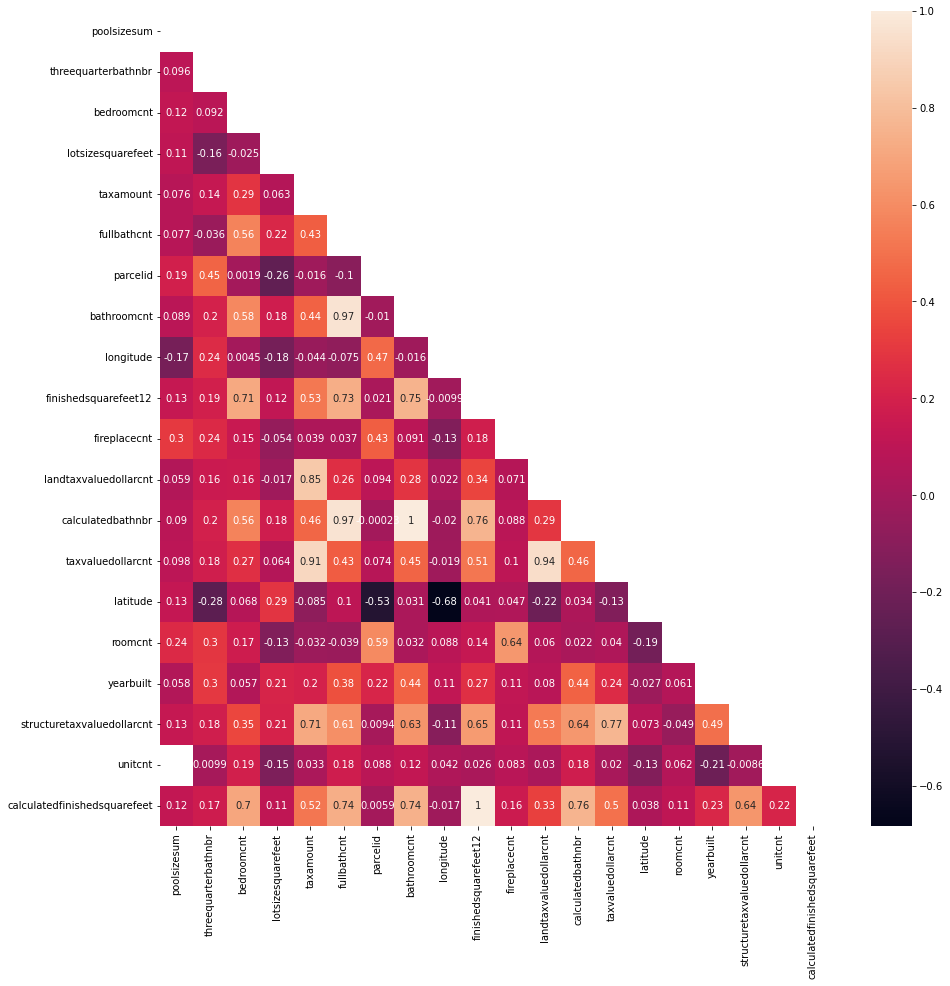

In [29]:
#correlation with each other
col_numeric_filtered = [c for c in col_numeric_filtered if c!='assessmentyear']
fig, ax = plt.subplots(figsize=(15, 15)) 
mask = np.zeros_like(train_data[col_numeric_filtered].corr())
mask[np.triu_indices_from(mask)] = 1
sns.heatmap(train_data[col_numeric_filtered].corr(method='spearman'), mask= mask, ax= ax, annot= True)

<a id="3.2.4"></a>
#### Feature Importance via RF

data size reduced from 90275 to 40404
Features sorted by their score:
In sample MAE: 0.0615595614862349


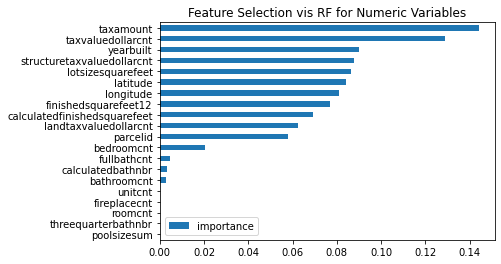

In [31]:
vname = 'logerror_wc_0.01'
train_data_temp = train_data[col_numeric_filtered+[vname]]
train_data_filtered = train_data_temp.dropna(how='any', axis=0)
print(f"data size reduced from {train_data.shape[0]} to {train_data_filtered.shape[0]}")
X = train_data_filtered[col_numeric_filtered]
Y = train_data_filtered['logerror_wc_0.01']
rf = RandomForestRegressor(max_depth=8)
rf.fit(X, Y)
y_pred = rf.predict(X)
print("Features sorted by their score:")
df_importance = pd.DataFrame(rf.feature_importances_,index=col_numeric_filtered,columns=['importance'])
ax = df_importance.sort_values('importance').plot(kind='barh')
ax.set_title('Feature Selection vis RF for Numeric Variables')
# print(f'oob score is {rf.oob_score_}')
print(f"In sample MAE: {mean_absolute_error(Y, y_pred)}")

In [ ]:
vname = 'logerror_wc_0.01'
col_keep = col_numeric_filtered+[vname]
col_dummy = [c for c in train_data.columns if "dummy_" in c]
colnames = col_keep + col_dummy
train_data_temp = train_data[colnames]
train_data_temp = train_data_temp.fillna(-999)
train_data_filtered = train_data_temp.dropna(how='any', axis=0)
print(f"data size reduced from {train_data.shape[0]} to {train_data_filtered.shape[0]}")
X = train_data_filtered[col_numeric_filtered+col_dummy]
Y = train_data_filtered[vname]
rf = RandomForestRegressor(max_depth=8)
rf.fit(X, Y)
y_pred = rf.predict(X)
print("Features sorted by their score:")
df_importance = pd.DataFrame(rf.feature_importances_,index=col_numeric_filtered+col_dummy,columns=['importance'])
ax = df_importance.sort_values('importance').plot(kind='barh',figsize=(10,10))
ax.set_title('Feature Selection vis RF for All Variables')
# print(f'oob score is {rf.oob_score_}')
print(f"Initial MAE: {mean_absolute_error(Y, y_pred)}")

data size reduced from 90275 to 90275
Features sorted by their score:
Initial MAE: 0.05924184585312556
